In [ ]:
!pip install -q kaggle

In [ ]:

!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'aananehsansiam/audio-dataset-of-scream-and-non-scream'

Dataset URL: https://www.kaggle.com/datasets/aananehsansiam/audio-dataset-of-scream-and-non-scream
License(s): unknown
100% 331M/333M [00:04<00:00, 71.8MB/s]
100% 333M/333M [00:04<00:00, 76.4MB/s]


In [ ]:
import zipfile

In [ ]:
dataset_zip = zipfile.ZipFile('audio-dataset-of-scream-and-non-scream.zip', 'r')

dataset_zip.extractall()

dataset_zip.close()

### TRAINING DATA

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import sklearn.metrics
import librosa

from tensorflow.keras import layers, models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = 'Converted_Separately'

data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['scream' 'non_scream']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 3128
Number of examples per label: 1583
Example file tensor: tf.Tensor(b'Converted_Separately/scream/289.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:2189]
val_files = filenames[2189:2658]
test_files = filenames[2658:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Training set size 2189
Validation set size 469
Test set size 470


In [ ]:
test_file = tf.io.read_file(DATASET_PATH+'/scream/1201.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([61856, 2])

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)

  shape = tf.shape(audio)

  if shape.shape[0] > 1 and shape[1] > 1:
    audio = tf.reduce_mean(audio, axis=1, keepdims=False)
  return audio

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)

  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

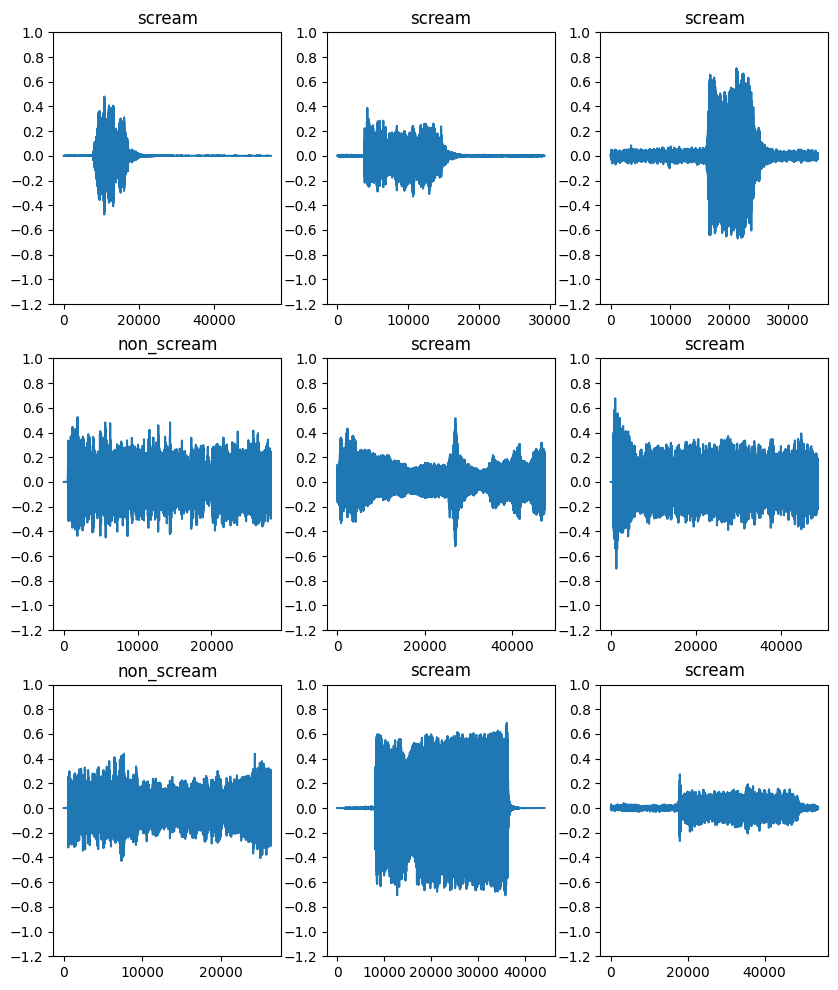

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 64000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [64000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=64000))

Label: scream
Waveform shape: (55040,)
Spectrogram shape: (499, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

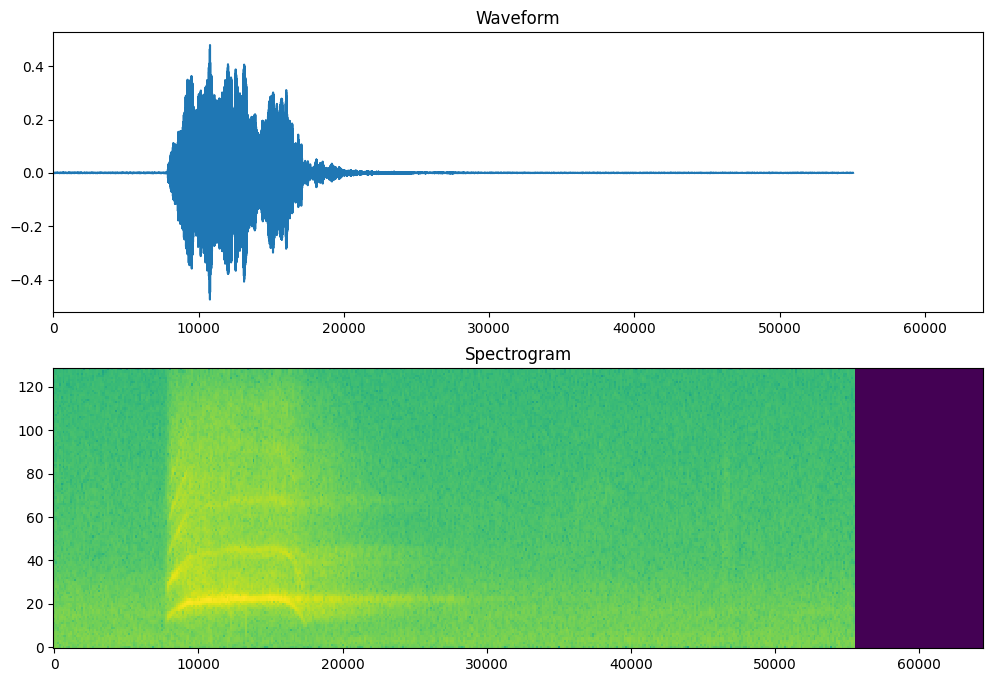

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 64000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

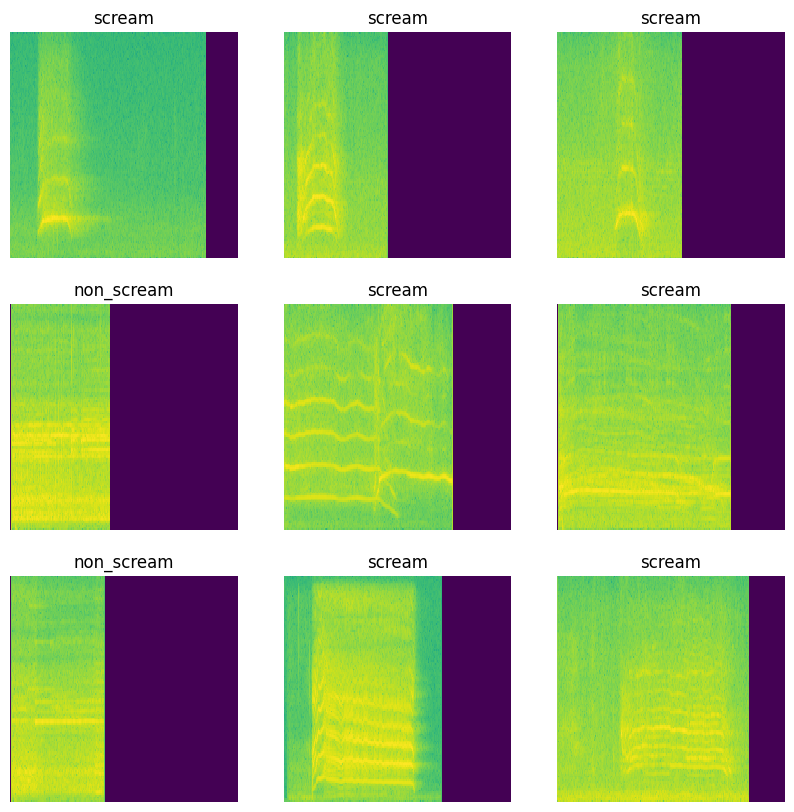

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
def preprocess_audio(audio, label):
    # Memastikan dimensi yang benar
    audio = tf.expand_dims(audio, axis=-1)  # Menambahkan dimensi channel jika diperlukan
    print(f"Bentuk audio setelah preprocessing: {audio.shape}")  # Cek bentuk
    return audio, label


In [ ]:
def prepare_dataset(ds, batch_size=64, is_train_ds=True):
    def preprocess(spec, label):
        # Convert to tensor and ensure it's a float32 tensor
        spec = tf.convert_to_tensor(spec, dtype=tf.float32)

        # Use tf.shape to handle tensors with unknown rank
        spec_rank = tf.rank(spec)

        # Conditionally add dimensions based on the tensor's rank
        spec = tf.cond(
            tf.equal(spec_rank, 2),
            lambda: tf.expand_dims(spec, axis=-1),  # If 2D, add channel dimension
            lambda: spec  # Otherwise, keep as is
        )

        # Ensure 3D tensor before resizing
        spec = tf.ensure_shape(spec, [None, None, None])

        # Resize spectrogram to 32x32
        spec_resized = tf.image.resize(spec, [32, 32])

        # Ensure the final shape is [32, 32, 1]
        spec_resized = tf.ensure_shape(spec_resized, [32, 32, 1])

        return spec_resized, label

    # If the input is already a dataset (like spectrogram_ds)
    if isinstance(ds, tf.data.Dataset):
        processed_ds = ds.map(
            lambda spec, label: preprocess(spec, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        # If the input is a list of files
        def process_file(file_path):
            waveform, label = get_waveform_and_label(file_path)
            spectrogram, label_id = get_spectrogram_and_label_id(waveform, label)
            return spectrogram, label_id

        # Create dataset from file paths
        processed_ds = tf.data.Dataset.from_tensor_slices(ds)
        processed_ds = processed_ds.map(
            process_file,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        processed_ds = processed_ds.map(
            lambda spec, label: preprocess(spec, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Debug: print dataset details
    processed_ds = processed_ds.map(
        lambda spec, label: (tf.debugging.check_numerics(spec, "Invalid spectrogram"), label)
    )

    # Shuffle and batch only training dataset
    if is_train_ds:
        processed_ds = processed_ds.shuffle(buffer_size=1000)

    processed_ds = processed_ds.batch(batch_size)
    return processed_ds.cache().prefetch(tf.data.AUTOTUNE)

# Additional debugging
print("Spectrogram dataset details:")
for spec, label in spectrogram_ds.take(1):
    print("Spectrogram type:", type(spec))
    print("Spectrogram shape:", spec.shape)
    print("Spectrogram dtype:", spec.dtype)
    print("Label type:", type(label))
    print("Label shape:", label.shape)
    print("Label dtype:", label.dtype)

# Prepare datasets
train_ds = prepare_dataset(spectrogram_ds, is_train_ds=True)
val_ds = prepare_dataset(val_files, is_train_ds=False)

# Verify dataset shapes
print("\nTrain dataset:")
for spec, label in train_ds.take(1):
    print("Spectrogram shape:", spec.shape)
    print("Label shape:", label.shape)

print("\nValidation dataset:")
for spec, label in val_ds.take(1):
    print("Spectrogram shape:", spec.shape)
    print("Label shape:", label.shape)

Spectrogram dataset details:
Spectrogram type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Spectrogram shape: (499, 129, 1)
Spectrogram dtype: <dtype: 'float32'>
Label type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Label shape: ()
Label dtype: <dtype: 'int64'>

Train dataset:
Spectrogram shape: (64, 32, 32, 1)
Label shape: (64,)

Validation dataset:
Spectrogram shape: (64, 32, 32, 1)
Label shape: (64,)


In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (499, 129, 1)


In [ ]:
spectrogram_data = np.array([spec.numpy() for spec, _ in spectrogram_ds])

# Create and adapt the normalization layer
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_data)

model = models.Sequential([
    layers.Input(shape=(32, 32, 1)),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,781 (2.61 MB)

 Trainable params: 683,330 (2.61 MB)

 Non-trainable params: 451 (1.77 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        verbose=1
    )
]

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 511ms/step - accuracy: 0.7859 - loss: 0.7075 - val_accuracy: 0.7953 - val_loss: 0.5013 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - accuracy: 0.8820 - loss: 0.3256 - val_accuracy: 0.7846 - val_loss: 0.4790 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9057 - loss: 0.2397
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - accuracy: 0.9058 - loss: 0.2398 - val_accuracy: 0.6887 - val_loss: 0.8233 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9185 - loss: 0.1882
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 398ms/step - accuracy: 0.9187 - loss: 0.1883 - val_accuracy: 0.6695 - val_loss: 1.1101 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

<ipython-input-50-7bc2164cf898>:50: RuntimeWarning: invalid value encountered in divide
  mel_normalized = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

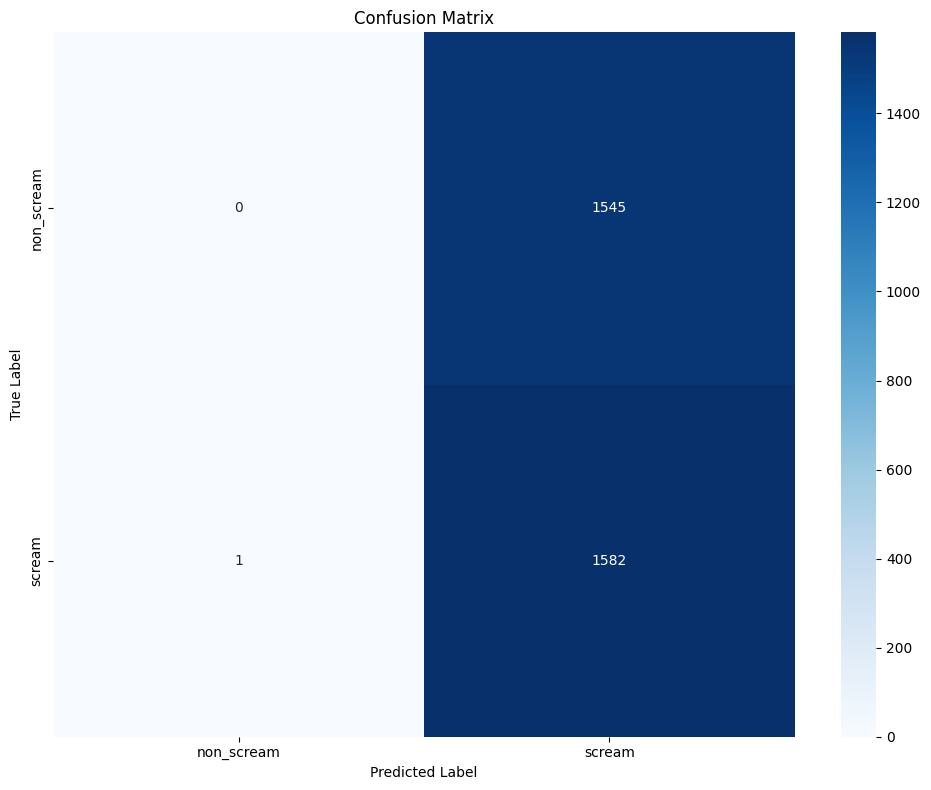


Classification Report:
              precision    recall  f1-score   support

  non_scream       0.00      0.00      0.00      1545
      scream       0.51      1.00      0.67      1583

    accuracy                           0.51      3128
   macro avg       0.25      0.50      0.34      3128
weighted avg       0.26      0.51      0.34      3128


Performance Summary:
 Accuracy: 50.58%
Precision: 25.60%
Recall: 50.58%
F1 Score: 34.00%


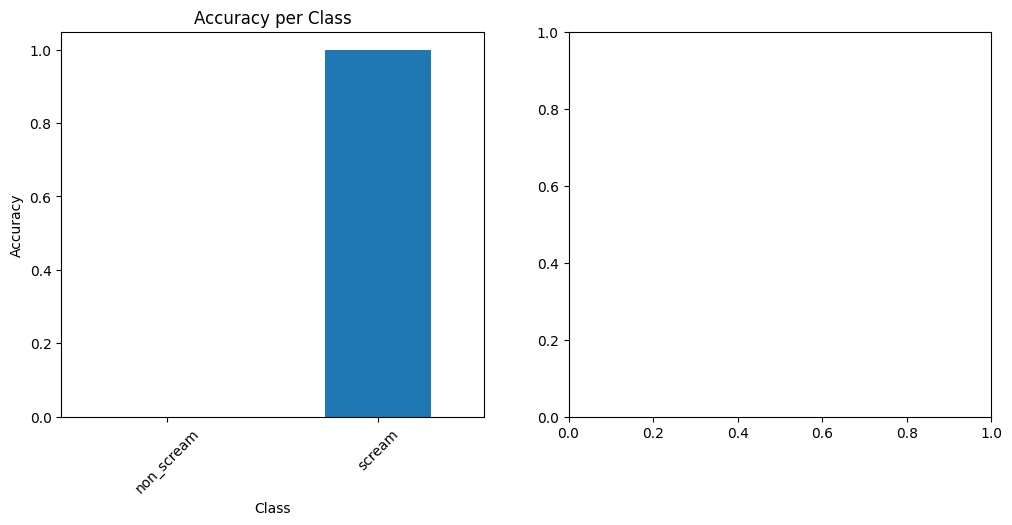

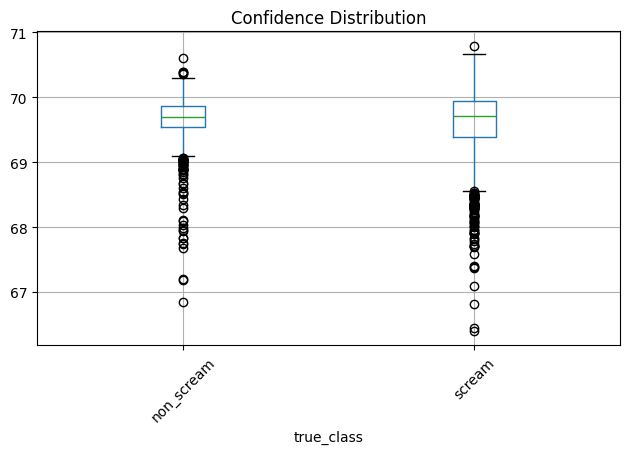

In [ ]:
def comprehensive_dataset_evaluation(model, data_dir, class_names):
    """
    Evaluasi komprehensif untuk seluruh dataset audio
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    from sklearn.metrics import (
        confusion_matrix,
        classification_report,
        accuracy_score,
        precision_score,
        recall_score,
        f1_score
    )

    # Inisialisasi list untuk menyimpan hasil
    evaluation_results = []

    # Mendapatkan semua file audio dari kedua folder
    for class_name in class_names:
        class_dir = Path(data_dir) / class_name.lower()

        # Cek apakah direktori ada
        if not class_dir.exists():
            print(f"Direktori {class_dir} tidak ditemukan!")
            continue

        # Proses setiap file audio di kelas
        for audio_file in class_dir.glob('*.wav'):
            try:
                # Baca file audio
                waveform, sample_rate = librosa.load(str(audio_file), sr=16000)

                # Ekstraksi spectrogram mel
                mel_spectrogram = librosa.feature.melspectrogram(
                    y=waveform,
                    sr=sample_rate,
                    n_mels=32,
                    n_fft=2048,
                    hop_length=512
                )

                # Konversi ke desibel
                mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

                # Normalisasi
                mel_normalized = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

                # Reshape sesuai input model
                mel_input = mel_normalized[..., np.newaxis]
                mel_input = tf.image.resize(mel_input, (32, 32))

                # Prediksi
                prediction = model.predict(mel_input[tf.newaxis, ...])
                probabilities = tf.nn.softmax(prediction[0])

                # Klasifikasi
                predicted_class_idx = np.argmax(probabilities)
                predicted_class = class_names[predicted_class_idx]
                confidence = np.max(probabilities) * 100

                # Simpan hasil
                evaluation_results.append({
                    'filename': audio_file.name,
                    'true_class': class_name,
                    'predicted_class': predicted_class,
                    'confidence': confidence,
                    'is_correct': predicted_class == class_name
                })

            except Exception as e:
                print(f"Error processing {audio_file}: {e}")

    # Konversi ke DataFrame
    results_df = pd.DataFrame(evaluation_results)

    # Pastikan ada data yang diproses
    if len(results_df) == 0:
        print("Tidak ada data yang berhasil diproses!")
        return None

    # Hitung metrik performa
    accuracy = accuracy_score(
        results_df['true_class'],
        results_df['predicted_class']
    )
    precision = precision_score(
        results_df['true_class'],
        results_df['predicted_class'],
        average='weighted'
    )
    recall = recall_score(
        results_df['true_class'],
        results_df['predicted_class'],
        average='weighted'
    )
    f1 = f1_score(
        results_df['true_class'],
        results_df['predicted_class'],
        average='weighted'
    )

    # Confusion Matrix
    cm = confusion_matrix(
        results_df['true_class'],
        results_df['predicted_class'],
        labels=class_names
    )

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Print Laporan Klasifikasi
    print("\nClassification Report:")
    print(classification_report(
        results_df['true_class'],
        results_df['predicted_class']
    ))

    # Print Ringkasan Performa
    print("\nPerformance Summary:")
    print(f" Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")

    # Visualisasi Distribusi Prediksi
    plt.figure(figsize=(12, 5))

    # Plot Akurasi per Kelas
    plt.subplot(1, 2, 1)
    class_accuracy = results_df.groupby('true_class')['is_correct'].mean()
    class_accuracy.plot(kind='bar')
    plt.title('Accuracy per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    # Plot Distribusi Confidence
    plt.subplot(1, 2, 2)
    results_df.boxplot(column='confidence', by='true_class')
    plt.title('Confidence Distribution')
    plt.suptitle('')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return results_df

# Jalankan evaluasi
class_names = ['non_scream', 'scream']
dataset_evaluation = comprehensive_dataset_evaluation(
    model,
    data_dir,
    class_names
)

# Simpan hasil evaluasi (opsional)
if dataset_evaluation is not None:
    dataset_evaluation.to_csv('dataset_evaluation_results.csv', index=False)

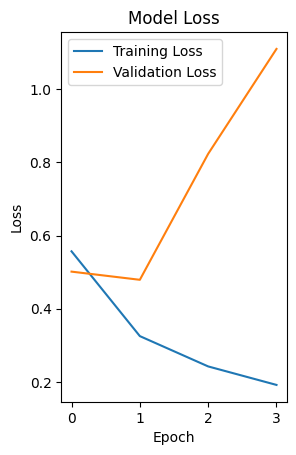

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

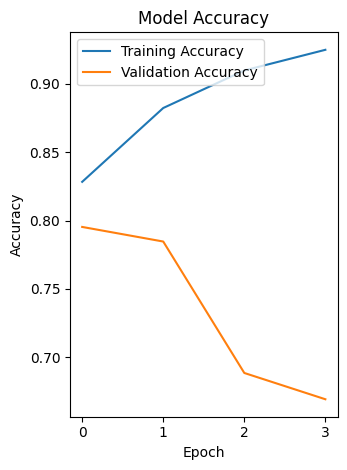

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7801 - loss: 0.4876

Test Loss: 0.4790
Test Accuracy: 0.7846


In [ ]:
y_true = []
y_pred = []

for specs, labels in val_ds:
    predictions = model.predict(specs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

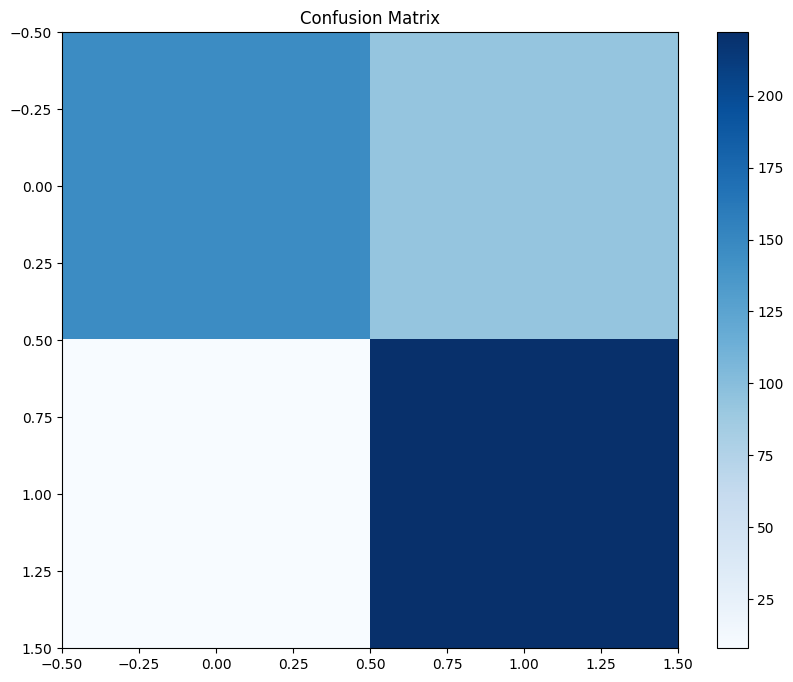

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

In [ ]:
print("\nClassification Report:")
print(sklearn.metrics.classification_report(y_true, y_pred, target_names=commands))


Classification Report:
              precision    recall  f1-score   support

      scream       0.95      0.61      0.74       239
  non_scream       0.70      0.97      0.81       230

    accuracy                           0.78       469
   macro avg       0.83      0.79      0.78       469
weighted avg       0.83      0.78      0.78       469



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


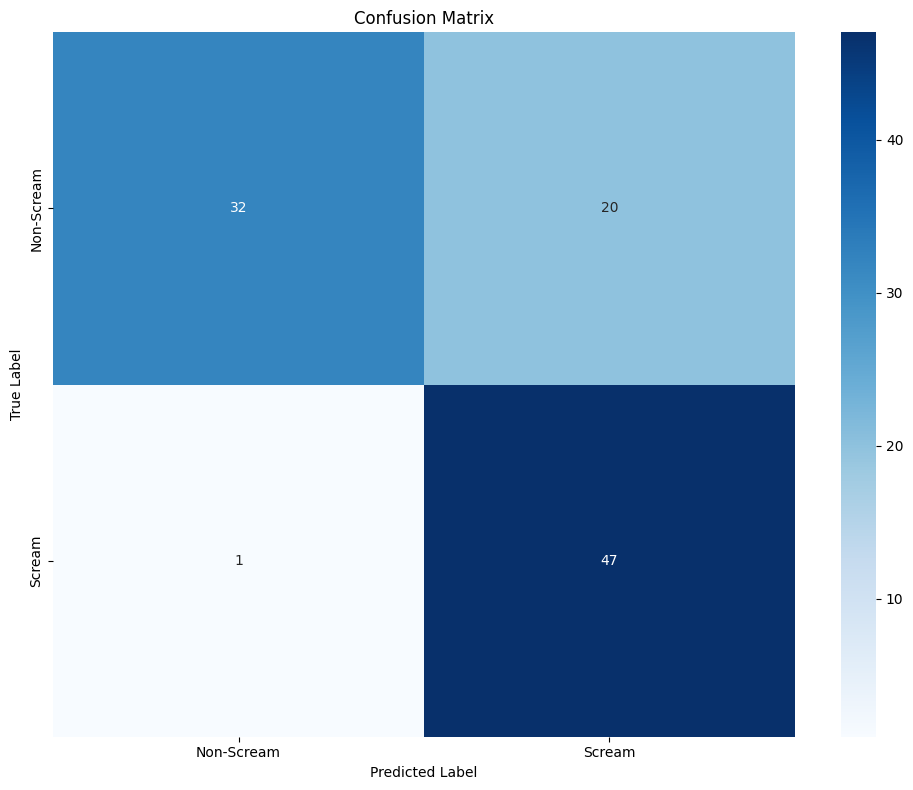


Classification Report:
              precision    recall  f1-score   support

  Non-Scream       0.97      0.62      0.75        52
      Scream       0.70      0.98      0.82        48

    accuracy                           0.79       100
   macro avg       0.84      0.80      0.79       100
weighted avg       0.84      0.79      0.78       100



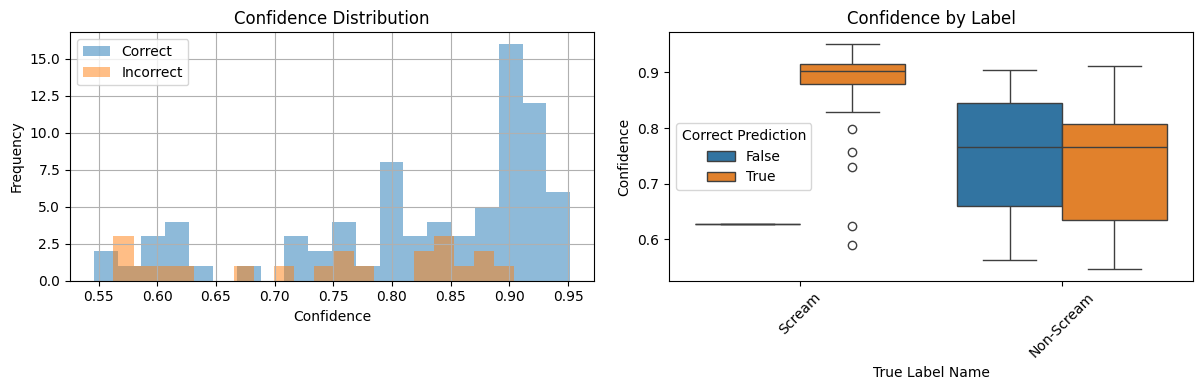


Misclassified Samples:
    True Label  Predicted Label  Confidence  Correct Prediction  \
8            0                1    0.829533               False   
12           0                1    0.904298               False   
17           0                1    0.563989               False   
29           0                1    0.820023               False   
40           0                1    0.844365               False   

   True Label Name Predicted Label Name  
8       Non-Scream               Scream  
12      Non-Scream               Scream  
17      Non-Scream               Scream  
29      Non-Scream               Scream  
40      Non-Scream               Scream  

Prediction Table:
   True Label  Predicted Label  Confidence  Correct Prediction  \
0           1                1    0.920925                True   
1           1                1    0.828971                True   
2           0                0    0.604857                True   
3           1                1    0.88

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)

def create_prediction_table(
    model,
    dataset,
    class_names=['Non-Scream', 'Scream'],
    num_samples=100
):
    """
    Buat tabel prediksi komprehensif

    Parameters:
    - model: Model yang sudah dilatih
    - dataset: Dataset untuk prediksi
    - class_names: Nama kelas
    - num_samples: Jumlah sampel yang akan diprediksi
    """
    # Persiapkan list untuk menyimpan hasil
    true_labels = []
    predicted_labels = []
    confidences = []

    # Iterasi dataset
    for specs, labels in dataset.take(num_samples // 64 + 1):
        # Prediksi
        predictions = model.predict(specs)

        # Konversi prediksi
        pred_labels = np.argmax(predictions, axis=1)
        pred_confidences = np.max(predictions, axis=1)

        # Tambahkan ke list
        true_labels.extend(labels.numpy())
        predicted_labels.extend(pred_labels)
        confidences.extend(pred_confidences)

    # Potong sesuai num_samples
    true_labels = true_labels[:num_samples]
    predicted_labels = predicted_labels[:num_samples]
    confidences = confidences[:num_samples]

    # Buat DataFrame
    prediction_df = pd.DataFrame({
        'True Label': true_labels,
        'Predicted Label': predicted_labels,
        'Confidence': confidences,
        'Correct Prediction': np.array(true_labels) == np.array(predicted_labels)
    })

    # Tambahkan nama kelas
    prediction_df['True Label Name'] = [class_names[label] for label in prediction_df['True Label']]
    prediction_df['Predicted Label Name'] = [class_names[label] for label in prediction_df['Predicted Label']]

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Hitung metrik
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted'
    )

    # Cetak laporan klasifikasi
    print("\nClassification Report:")
    print(classification_report(
        true_labels,
        predicted_labels,
        target_names=class_names
    ))

    # Tambahkan ringkasan ke DataFrame
    summary_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score'],
        'Value': [precision, recall, f1]
    })

    # Visualisasi distribusi confidence
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    prediction_df[prediction_df['Correct Prediction']]['Confidence'].hist(
        alpha=0.5, label='Correct', bins=20
    )
    prediction_df[~prediction_df['Correct Prediction']]['Confidence'].hist(
        alpha=0.5, label='Incorrect', bins=20
    )
    plt.title('Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(
        x='True Label Name',
        y='Confidence',
        hue='Correct Prediction',
        data=prediction_df
    )
    plt.title('Confidence by Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Tampilkan beberapa sampel yang salah diklasifikasi
    misclassified = prediction_df[~prediction_df['Correct Prediction']]
    print("\nMisclassified Samples:")
    print(misclassified.head())

    return prediction_df, summary_df

# Gunakan fungsi
prediction_table, summary_table = create_prediction_table(
    model,
    val_ds,
    class_names=['Non-Scream', 'Scream']
)

# Tampilkan tabel
print("\nPrediction Table:")
print(prediction_table.head(10))

print("\nSummary Table:")
print(summary_table)

Misclassification Analysis:

False Negatives (Missed Screams):
Total: 1
Confidence Statistics:
count    1.000000
mean     0.628281
std           NaN
min      0.628281
25%      0.628281
50%      0.628281
75%      0.628281
max      0.628281
Name: Confidence, dtype: float64

False Positives (False Alarms):
Total: 20
Confidence Statistics:
count    20.000000
mean      0.751388
std       0.118131
min       0.562764
25%       0.659604
50%       0.766890
75%       0.844698
max       0.904298
Name: Confidence, dtype: float64


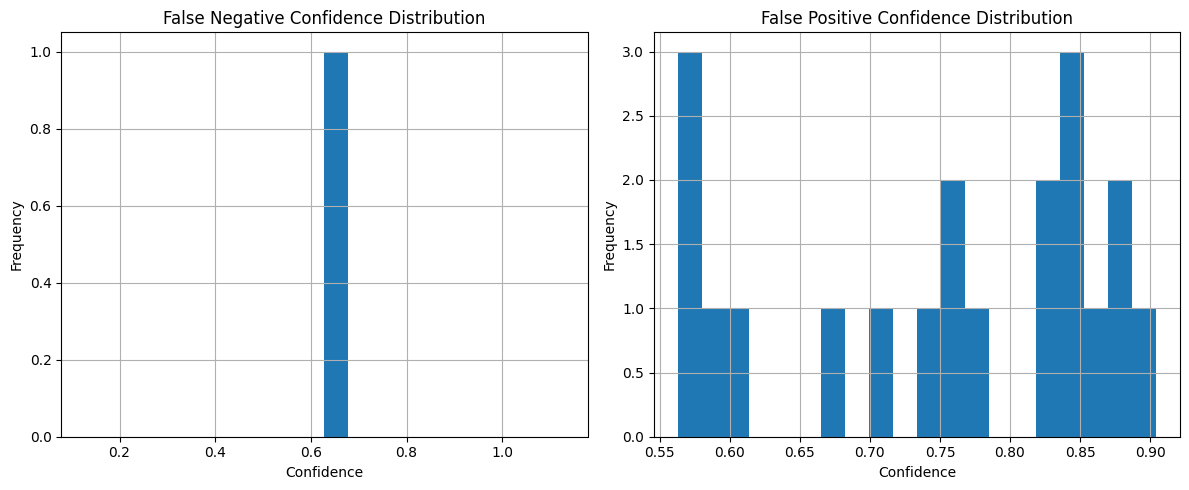

In [ ]:
def advanced_misclassification_analysis(prediction_table):
    # Pisahkan kategori kesalahan
    false_negatives = prediction_table[
        (prediction_table['True Label Name'] == 'Scream') &
        (~prediction_table['Correct Prediction'])
    ]

    false_positives = prediction_table[
        (prediction_table['True Label Name'] == 'Non-Scream') &
        (~prediction_table['Correct Prediction'])
    ]

    print("Misclassification Analysis:")
    print("\nFalse Negatives (Missed Screams):")
    print(f"Total: {len(false_negatives)}")
    print("Confidence Statistics:")
    print(false_negatives['Confidence'].describe())

    print("\nFalse Positives (False Alarms):")
    print(f"Total: {len(false_positives)}")
    print("Confidence Statistics:")
    print(false_positives['Confidence'].describe())

    # Visualisasi confidence distribusi kesalahan
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    false_negatives['Confidence'].hist(bins=20)
    plt.title('False Negative Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    false_positives['Confidence'].hist(bins=20)
    plt.title('False Positive Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return false_negatives, false_positives

# Jalankan analisis
false_negatives, false_positives = advanced_misclassification_analysis(prediction_table)

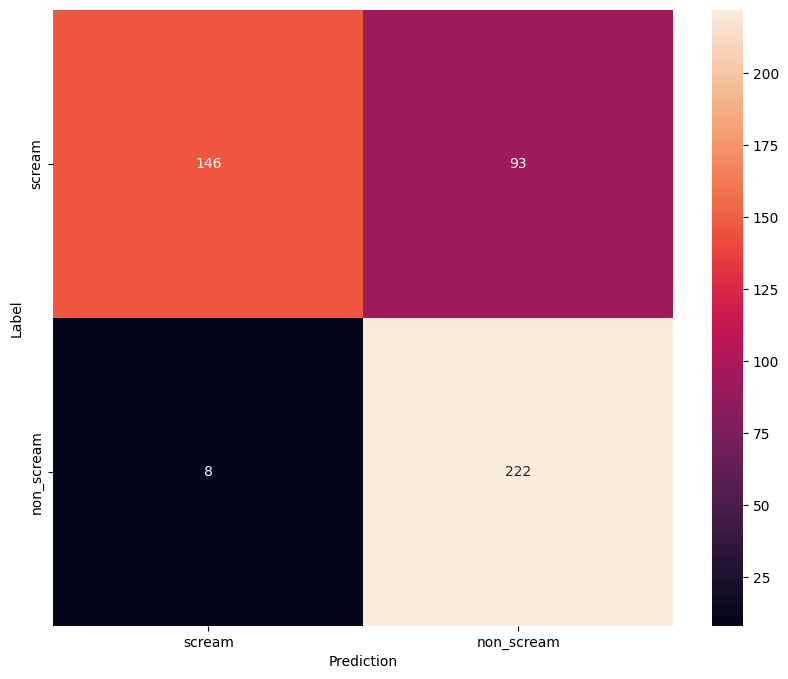

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
model.save('scream_detection_model.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('scream_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpl_tp04ql'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137767923056880: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  137767923875184: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  137767965453552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137767927093680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137767927101072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137767927097728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137767927103184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137767927089280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137767927092976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137767927092448: TensorSpec(shape=(), dtype=tf.resource, name=None)
